# One Pixel Attack Tutorial

![](images/horse.png "I'm a normal horse, nothing suspicious here") ![](images/horse-attack.png "I'm an attack horse, grr")

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from networks.wide_resnet import WideResNet
from networks.pure_cnn import PureCnn
from helper import get_class_names, plot_image

In [3]:
matplotlib.style.use('ggplot')

### Load Data

Load the Cifar10 dataset and all necessary metadata.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# Obtain the names of the 10 classes in cifar10
class_names = get_class_names()
print(class_names)

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Models

Load various pre-trained Neural Network models in the `networks/models` directory. If the models don't exist or cannot be loaded, they will be trained here. 

Keras will need to also download the Cifar10 dataset if it is not cached locally already.

In [6]:
wide_resnet = WideResNet()
pure_cnn = PureCnn()

models = [pure_cnn, wide_resnet]

Successfully loaded wide_resnet
Successfully loaded pure_cnn


### Calculate Model Accuracies

In [7]:
final_results = pd.DataFrame()
final_results['name'] = [model.name for model in models]
final_results['accuracy'] = [model.accuracy() for model in models]

In [8]:
final_results

,name,accuracy
0,pure_cnn,0.3548
1,wide_resnet,0.9534


### Image Perturbation

In [9]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for x in pixels:
        x_pos, y_pos, rgb = *x[:2], x[2:]
        img[x_pos][y_pos] = rgb
    return img

In [10]:
def predict_untargeted(x, *args):
    img, correct_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return prediction[correct_class]

In [11]:
def predict_targeted(x, *args):
    img, target_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return 1 - prediction[target_class]

### Untargeted Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

In [46]:
def attack_untargeted_iteration(img, model, pixel_count=1, iterations=30,
                                population=100, mutation=0.5, recombination=0.7, 
                                stop_threshold=-0.01, callback=None):
    print('Attacking image', img)
    
    args = x_test[img], y_test[img], model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_untargeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    predicted_probs = model.predict(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [47]:
def untargeted_callback(x, convergence, args):
    img, correct_class, model = args
    correct_class = correct_class[0]
    img_perturbed = perturb_image(x, img)
    confidence = model.predict(img_perturbed)
    prediction = np.argmax(confidence)
    print('Confidence:', confidence[correct_class])
    if (prediction != correct_class):
        return True # Do it this way because returning it directly will prevent early halting

Attacking image 99
Confidence: 0.9765877
Confidence: 0.9765877
Confidence: 0.8886552
Confidence: 0.49795097


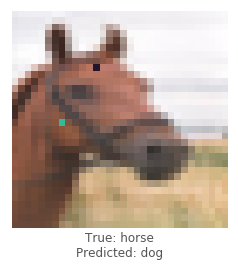

In [48]:
_ = attack_untargeted_iteration(99, wide_resnet, pixel_count=2, callback=untargeted_callback)

In [ ]:
def attack_untargeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=100, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=untargeted_callback):
    print('Targeting model', model.name)
    
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Iteration', i)
        result = attack_untargeted_iteration(
            img, model, pixel_count, iterations,
            population, mutation, recombination, 
            stop_threshold, callback)
        results.append(result)
        print()
    
    return pd.DataFrame(
        data=results,
        columns=['image_index', 'true_class', 'predicted_class', 'success', 'predicted_probs', 'attack_image']
    )

Targeting model wide_resnet
Iteration 0
Attacking image 6662
Confidence: 0.06800787


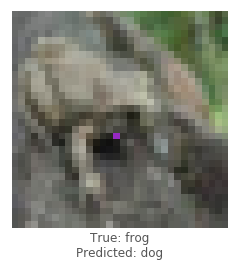


Iteration 1
Attacking image 1223
Confidence: 0.9999286
Confidence: 0.9999056
Confidence: 0.9999056
Confidence: 0.9998815
Confidence: 0.99986696
Confidence: 0.9998654
Confidence: 0.9998654
Confidence: 0.9998647
Confidence: 0.9998647
Confidence: 0.9998647
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446


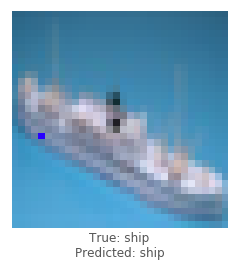


Iteration 2
Attacking image 3358
Confidence: 0.9909355
Confidence: 0.982907
Confidence: 0.98085004
Confidence: 0.9601557
Confidence: 0.9561567
Confidence: 0.9561567
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460164
Confidence: 0.9460164
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016


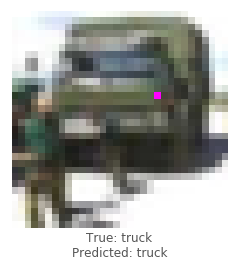


Iteration 3
Attacking image 8969
Confidence: 0.9999987
Confidence: 0.9999981
Confidence: 0.9999976
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714


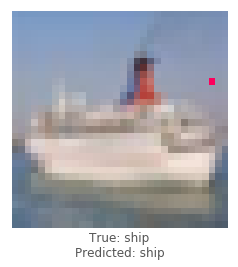


Iteration 4
Attacking image 242
Confidence: 0.54335105
Confidence: 0.45349857


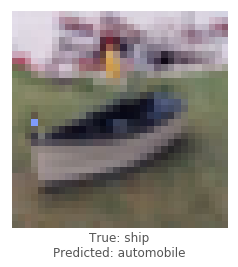


Iteration 5
Attacking image 8714
Confidence: 0.99286133
Confidence: 0.97499824
Confidence: 0.9455835
Confidence: 0.94273895
Confidence: 0.94273895
Confidence: 0.9341543
Confidence: 0.9320416
Confidence: 0.9317245
Confidence: 0.9309782
Confidence: 0.93060887
Confidence: 0.93060887
Confidence: 0.9305272
Confidence: 0.9305272
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056


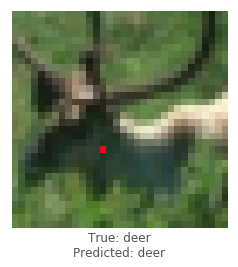


Iteration 6
Attacking image 1105
Confidence: 0.00024960208


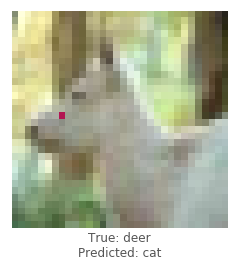


Iteration 7
Attacking image 6831
Confidence: 0.9997042
Confidence: 0.9997042
Confidence: 0.99961436
Confidence: 0.9995746
Confidence: 0.9995683
Confidence: 0.9995497
Confidence: 0.9995448
Confidence: 0.9995389
Confidence: 0.9995353
Confidence: 0.9995334
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527


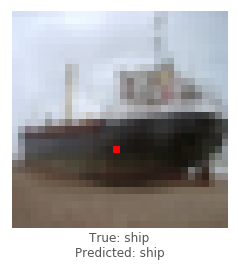


Iteration 8
Attacking image 8024
Confidence: 0.9969797
Confidence: 0.9962708
Confidence: 0.99622774
Confidence: 0.99622774
Confidence: 0.9961045
Confidence: 0.99596775
Confidence: 0.9959099
Confidence: 0.9959091
Confidence: 0.99589396
Confidence: 0.9958925
Confidence: 0.9958722
Confidence: 0.99587184
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934


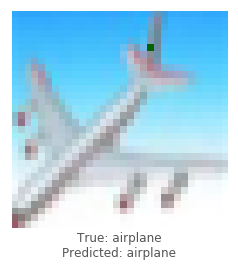


Iteration 9
Attacking image 344
Confidence: 0.99881387
Confidence: 0.9986278
Confidence: 0.9985953
Confidence: 0.9985846
Confidence: 0.99855906
Confidence: 0.99855906
Confidence: 0.99854076
Confidence: 0.99854076
Confidence: 0.9985404
Confidence: 0.9985404
Confidence: 0.9985399
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398


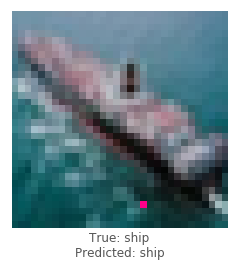


Iteration 10
Attacking image 8864
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999957
Confidence: 0.9999956
Confidence: 0.9999932
Confidence: 0.9999919
Confidence: 0.9999914
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106


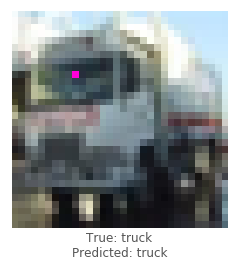


Iteration 11
Attacking image 8530
Confidence: 0.99997306
Confidence: 0.99994195
Confidence: 0.99991906
Confidence: 0.99991906
Confidence: 0.99989927
Confidence: 0.99985075
Confidence: 0.9998468
Confidence: 0.9998468
Confidence: 0.9998424
Confidence: 0.99984217
Confidence: 0.999841
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026


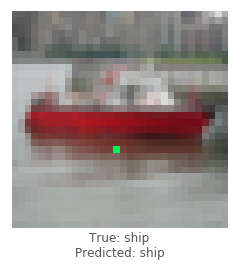


Iteration 12
Attacking image 6426
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.99999785
Confidence: 0.9999975
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974


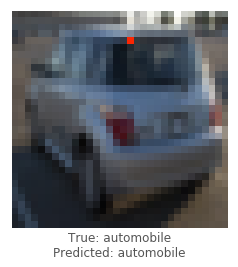


Iteration 13
Attacking image 721
Confidence: 0.99868435
Confidence: 0.99830973
Confidence: 0.99818915
Confidence: 0.998054
Confidence: 0.9979651
Confidence: 0.9979468
Confidence: 0.9979371
Confidence: 0.9979371
Confidence: 0.9979321
Confidence: 0.9979321
Confidence: 0.9979321
Confidence: 0.9979315
Confidence: 0.9979315
Confidence: 0.9979315
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136


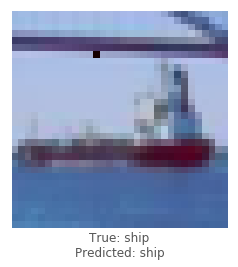


Iteration 14
Attacking image 7692
Confidence: 0.9999124
Confidence: 0.99991226
Confidence: 0.9998944
Confidence: 0.9998808
Confidence: 0.9997814
Confidence: 0.9997814
Confidence: 0.9997745
Confidence: 0.9997664
Confidence: 0.99976236
Confidence: 0.99975115
Confidence: 0.999747
Confidence: 0.99974376
Confidence: 0.99974376
Confidence: 0.99974364
Confidence: 0.99974364
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435


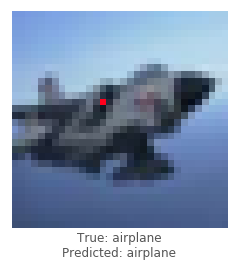


Iteration 15
Attacking image 6214
Confidence: 0.9986266
Confidence: 0.9986148
Confidence: 0.9985884
Confidence: 0.9983443
Confidence: 0.9982015
Confidence: 0.9981974
Confidence: 0.9981974
Confidence: 0.99818736
Confidence: 0.9981667
Confidence: 0.9981667
Confidence: 0.9981633
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243


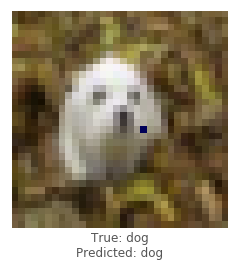


Iteration 16
Attacking image 3143
Confidence: 0.99998605
Confidence: 0.99998605
Confidence: 0.99998605
Confidence: 0.9999838
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295


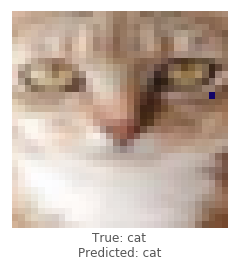


Iteration 17
Attacking image 6559
Confidence: 0.27595958


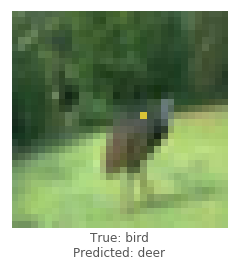


Iteration 18
Attacking image 6175
Confidence: 0.8414955
Confidence: 0.8111938
Confidence: 0.7769272
Confidence: 0.7652893
Confidence: 0.74418306
Confidence: 0.74418306
Confidence: 0.74418306
Confidence: 0.74342304
Confidence: 0.7423668
Confidence: 0.7411415
Confidence: 0.7409872
Confidence: 0.74055856
Confidence: 0.74055856
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784


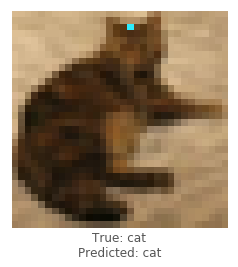


Iteration 19
Attacking image 6330
Confidence: 0.9997459
Confidence: 0.9997459
Confidence: 0.9996911
Confidence: 0.99960023
Confidence: 0.99960023
Confidence: 0.99960023
Confidence: 0.99958163
Confidence: 0.99958163
Confidence: 0.9995757
Confidence: 0.99957496
Confidence: 0.99957377
Confidence: 0.9995696
Confidence: 0.99956924
Confidence: 0.9995691
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569


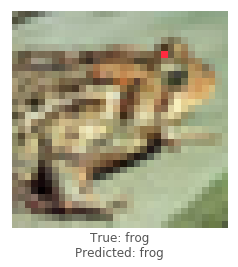


Iteration 20
Attacking image 7021
Confidence: 0.9890633
Confidence: 0.9876973
Confidence: 0.9702526
Confidence: 0.9702526
Confidence: 0.96696603
Confidence: 0.96194935
Confidence: 0.96072656
Confidence: 0.96048695
Confidence: 0.9600179
Confidence: 0.9600179
Confidence: 0.9600179
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.9591738
Confidence: 0.9591696
Confidence: 0.9591696
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666


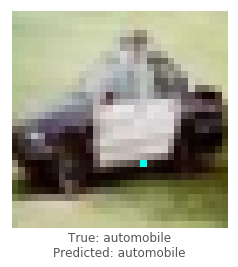


Iteration 21
Attacking image 3379
Confidence: 0.9973694
Confidence: 0.9968912
Confidence: 0.9930038
Confidence: 0.9920923
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.977099
Confidence: 0.9760243
Confidence: 0.97434956
Confidence: 0.96266973
Confidence: 0.95842606
Confidence: 0.95842606
Confidence: 0.9569971
Confidence: 0.9569971
Confidence: 0.9552101
Confidence: 0.9552101
Confidence: 0.9537646
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985


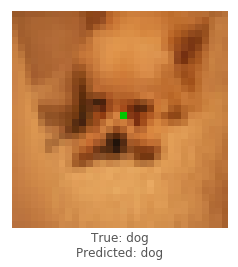


Iteration 22
Attacking image 1259
Confidence: 0.99932027
Confidence: 0.99932027
Confidence: 0.99932027
Confidence: 0.99915874
Confidence: 0.99445844
Confidence: 0.99433315
Confidence: 0.99404305
Confidence: 0.9928598
Confidence: 0.9924401
Confidence: 0.9924401
Confidence: 0.9920853
Confidence: 0.9920853
Confidence: 0.99205387
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147


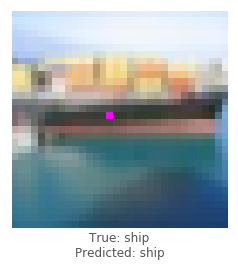


Iteration 23
Attacking image 5683
Confidence: 0.9999435
Confidence: 0.9999224
Confidence: 0.9999224
Confidence: 0.9999187
Confidence: 0.9999187
Confidence: 0.99991786
Confidence: 0.99991786
Confidence: 0.99991786
Confidence: 0.9999176
Confidence: 0.9999168
Confidence: 0.9999168
Confidence: 0.9999168
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167


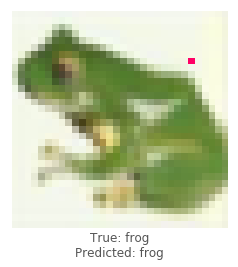


Iteration 24
Attacking image 7726
Confidence: 0.999954
Confidence: 0.99993396
Confidence: 0.99990964
Confidence: 0.9998523
Confidence: 0.9998349
Confidence: 0.9998223
Confidence: 0.9998223
Confidence: 0.9998223
Confidence: 0.99982053
Confidence: 0.9998204
Confidence: 0.99982005
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993


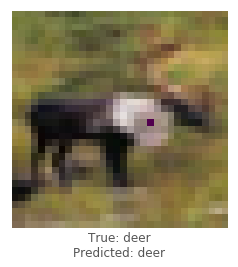


Iteration 25
Attacking image 759


In [ ]:
untargeted_results = attack_untargeted(wide_resnet)

In [45]:
untargeted_results

,image_index,true_class,predicted_class,success,predicted_probs,attack_image
0,6434,0,0,False,"[0.93864465, 0.0014470723, 9.012594e-05, 6.175...","[[[98, 166, 189], [101, 168, 191], [105, 173, ..."
1,848,2,2,False,"[0.37613243, 0.0012377605, 0.61433303, 0.00294...","[[[80, 80, 70], [76, 73, 64], [73, 69, 60], [8..."
2,6620,7,7,False,"[3.4860837e-05, 2.2225837e-05, 2.4331144e-05, ...","[[[7, 7, 9], [4, 3, 5], [4, 4, 6], [6, 6, 8], ..."


### Targeted Attack

In [65]:
def attack_targeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=100, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=None):
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print()
        print('Iteration', i)
        for target in range(10):
            if target == y_test[img]:
                continue
            print()
            print('Attacking image', img, 'with target', target, class_names[target])
            
            actual_class = y_test[img][0]
        
            plot_image(x_test[img], actual_class, class_names)
            
            args = x_test[img], target, model
            bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
            attack = predict_targeted

            res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=0.5, atol=stop_threshold, disp=True)

            attack_image = perturb_image(res.x, x_test[img])
            predicted_probs = model.predict(attack_image)
            predicted_class = np.argmax(predicted_probs)
            
            plot_image(attack_image, actual_class, class_names, predicted_class)

            result = img, predicted_class, actual_class, predicted_probs, attack_image
            results.append(result)
        
    return results

In [ ]:
def untargeted_callback(xk, convergence):
    print(xk)

Targeting model wide_resnet
Attacking image 6521 with target 0 airplane


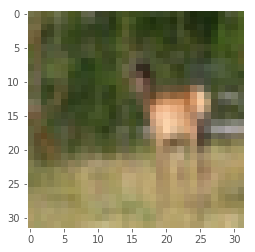

differential_evolution step 1: f(x)= 0.999988
differential_evolution step 2: f(x)= 0.999985
differential_evolution step 3: f(x)= 0.999982
differential_evolution step 4: f(x)= 0.999944
differential_evolution step 5: f(x)= 0.999944
differential_evolution step 6: f(x)= 0.999944


KeyboardInterrupt: 

In [66]:
targeted_results = attack_targeted(models[0])
targeted_results

### Show some successful attacks

Plot the first 9 misclassified images

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb